# Clima horario (Open-Meteo) — Visualizaciones + Dashboard mensual

Este notebook descarga (o reutiliza) datos horarios de **Open‑Meteo Archive**, construye un `DataFrame` limpio y genera un set de visualizaciones que dan **intuición rápida** de:
- Evolución a lo largo del tiempo
- Ciclos diarios típicos por mes (0–23)
- Evolución típica dentro del mes (día 1–31) con banda
- Un **dashboard 4×3** (12 meses) para una variable (por defecto: **temperatura**)

> Nota sobre variables:
> - `temperature_2m`, `relative_humidity_2m`: medidas/estimadas a **2 m sobre el suelo** (estándar meteorológico).
> - `wind_speed_10m`: a **10 m** (estándar).
> - `pressure_msl`: presión reducida a **nivel del mar** para comparación regional.


## 1) Configuración — ubicación, fechas y variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Para suavizado visual (splines)
from scipy.interpolate import CubicSpline

# -----------------------------
# Parámetros editables
# -----------------------------
# Coordenadas Catec
LAT = 20.535013503912094
LON = -100.21144639229682

# Rango (formato ISO YYYY-MM-DD)
START_DATE = "2025-01-01"
END_DATE   = "2025-09-02"   # ajusta si necesitas otro rango

# Variables a descargar (Open-Meteo)
HOURLY_VARS = [
    "temperature_2m",
    "relative_humidity_2m",
    "pressure_msl",
    "precipitation",
    "wind_speed_10m"
]

# Archivo local (cache)
CSV_PATH = "clima_horario_openmeteo.csv"


## 2) Descargar datos (o reutilizar CSV si ya existe)

In [2]:
import os, requests

def FetchOpenMeteoArchiveHourly(lat, lon, start_date, end_date, hourly_vars, timezone="auto"):
    """Descarga histórico horario desde Open‑Meteo Archive API."""
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ",".join(hourly_vars),
        "timezone": timezone
    }
    r = requests.get(url, params=params, timeout=60)
    r.raise_for_status()
    return r.json()

if os.path.exists(CSV_PATH):
    print(f"Usando CSV existente: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
else:
    print("Descargando datos desde Open‑Meteo...")
    data = FetchOpenMeteoArchiveHourly(LAT, LON, START_DATE, END_DATE, HOURLY_VARS, timezone="auto")
    df = pd.DataFrame(data["hourly"])
    df.to_csv(CSV_PATH, index=False)
    print(f"CSV guardado: {CSV_PATH}")

df.head()


Descargando datos desde Open‑Meteo...
CSV guardado: clima_horario_openmeteo.csv


time  temperature_2m  relative_humidity_2m  pressure_msl  \
0  2025-01-01T00:00            11.6                    47        1019.2   
1  2025-01-01T01:00            10.6                    52        1019.5   
2  2025-01-01T02:00             9.6                    54        1019.7   
3  2025-01-01T03:00             8.9                    54        1019.8   
4  2025-01-01T04:00             8.2                    56        1019.9   

   precipitation  wind_speed_10m  
0            0.0             8.5  
1            0.0             8.9  
2            0.0             9.1  
3            0.0             9.2  
4            0.0             8.3

## 3) Preparación del DataFrame

In [3]:
# Parsear tiempo
df["time"] = pd.to_datetime(df["time"])

# Features temporales útiles
df["month"] = df["time"].dt.to_period("M")   # 2025-01, 2025-02...
df["date"]  = df["time"].dt.date             # fecha (YYYY-MM-DD)
df["day"]   = df["time"].dt.day              # 1..31
df["hour"]  = df["time"].dt.hour             # 0..23

# Reordenar columnas para lectura
cols = ["time", "month", "date", "day", "hour"] + [c for c in df.columns if c not in ["time","month","date","day","hour"]]
df = df[cols]

print(df.dtypes)
df.head()


time                    datetime64[ns]
month                        period[M]
date                            object
day                              int32
hour                             int32
temperature_2m                 float64
relative_humidity_2m             int64
pressure_msl                   float64
precipitation                  float64
wind_speed_10m                 float64
dtype: object


time    month        date  day  hour  temperature_2m  \
0 2025-01-01 00:00:00  2025-01  2025-01-01    1     0            11.6   
1 2025-01-01 01:00:00  2025-01  2025-01-01    1     1            10.6   
2 2025-01-01 02:00:00  2025-01  2025-01-01    1     2             9.6   
3 2025-01-01 03:00:00  2025-01  2025-01-01    1     3             8.9   
4 2025-01-01 04:00:00  2025-01  2025-01-01    1     4             8.2   

   relative_humidity_2m  pressure_msl  precipitation  wind_speed_10m  
0                    47        1019.2            0.0             8.5  
1                    52        1019.5            0.0             8.9  
2                    54        1019.7            0.0             9.1  
3                    54        1019.8            0.0             9.2  
4                    56        1019.9            0.0             8.3

## 4) Utilidades de plot (promedios, bandas, splines)

In [4]:
def _safe_spline(x, y, num=400):
    """Spline cúbico natural para suavizado VISUAL.
    Si no hay suficientes puntos, regresa (x,y) sin suavizar.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    if len(x) < 4:
        return x, y
    xs = np.linspace(x.min(), x.max(), num)
    s = CubicSpline(x, y, bc_type="natural")
    return xs, s(xs)

def PlotTimeSeriesOverlayByMonth(df, col, ylabel, title):
    """Serie temporal completa: curvas sobrepuestas por mes."""
    plt.figure()
    for m, g in df.groupby("month"):
        plt.plot(g["time"], g[col], label=str(m))
    plt.xlabel("Tiempo")
    plt.ylabel(ylabel)
    plt.title(title + " — Serie horaria (curvas por mes)")
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    plt.show()

def PlotHourlyClimatologyWithBand(df, month_period, col, ylabel, title, p_low=25, p_high=75, use_spline=True):
    """Curva típica del mes: X=hora 0..23, promedio + banda (percentiles)."""
    dm = df[df["month"] == month_period]
    if dm.empty:
        return

    g = dm.groupby("hour")[col]
    mean = g.mean()
    p_lo = g.quantile(p_low/100)
    p_hi = g.quantile(p_high/100)

    x = mean.index.to_numpy()
    y_mean = mean.to_numpy()
    y_lo = p_lo.to_numpy()
    y_hi = p_hi.to_numpy()

    if use_spline:
        xs, yms = _safe_spline(x, y_mean)
        _,  yls = _safe_spline(x, y_lo)
        _,  yhs = _safe_spline(x, y_hi)

        # Evitar banda invertida por artefactos numéricos
        yls2 = np.minimum(yls, yhs)
        yhs2 = np.maximum(yls, yhs)

        # FIX: precipitación no puede ser negativa
        if col == "precipitation":
            yms  = np.clip(yms,  0, None)
            yls2 = np.clip(yls2, 0, None)
            yhs2 = np.clip(yhs2, 0, None)

        plt.figure()
        plt.plot(xs, yms, linewidth=2, label="Promedio (spline)")
        plt.fill_between(xs, yls2, yhs2, alpha=0.3, label=f"P{p_low}–P{p_high}")
        plt.scatter(x, y_mean, s=12, label="Promedio (puntos)")
    else:
        # Sin spline: aún así clip para precipitación por seguridad
        if col == "precipitation":
            y_mean = np.clip(y_mean, 0, None)
            y_lo   = np.clip(y_lo,   0, None)
            y_hi   = np.clip(y_hi,   0, None)

        plt.figure()
        plt.plot(x, y_mean, linewidth=2, label="Promedio")
        plt.fill_between(x, y_lo, y_hi, alpha=0.3, label=f"P{p_low}–P{p_high}")
        plt.scatter(x, y_mean, s=12, label="Promedio (puntos)")

    plt.xlabel("Hora del día (0–23)")
    plt.ylabel(ylabel)
    plt.title(f"{title} — {month_period} (curva diaria típica)")
    plt.xticks(range(0, 24, 1))
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

def PlotDayOfMonthIntradayBand(df, month_period, col, ylabel, title, p_low=25, p_high=75, use_spline=True):
    """Evolución dentro del mes: X=día 1..31
    Banda intradía (P25–P75 calculado usando las 24 horas de cada fecha).
    """
    dm = df[df["month"] == month_period].copy()
    if dm.empty:
        return

    # Por cada fecha, percentiles calculados con las horas del día (N≈24)
    per_date = (
        dm.groupby(["day","date"])[col]
          .agg(
              mean="mean",
              plo=lambda s: s.quantile(p_low/100),
              phi=lambda s: s.quantile(p_high/100),
          )
          .reset_index()
          .dropna()
    )

    g = per_date.groupby("day").agg(
        mean=("mean","mean"),
        plo=("plo","mean"),
        phi=("phi","mean"),
    ).reset_index().sort_values("day")

    x = g["day"].to_numpy()
    y_mean = g["mean"].to_numpy()
    y_lo = g["plo"].to_numpy()
    y_hi = g["phi"].to_numpy()

    if use_spline:
        xs, yms = _safe_spline(x, y_mean)
        _,  yls = _safe_spline(x, y_lo)
        _,  yhs = _safe_spline(x, y_hi)

        yls2 = np.minimum(yls, yhs)
        yhs2 = np.maximum(yls, yhs)

        # FIX: precipitación no puede ser negativa (overshoot del spline)
        if col == "precipitation":
            yms  = np.clip(yms,  0, None)
            yls2 = np.clip(yls2, 0, None)
            yhs2 = np.clip(yhs2, 0, None)

        plt.figure()
        plt.plot(xs, yms, linewidth=2, label="Promedio (spline)")
        plt.fill_between(xs, yls2, yhs2, alpha=0.3, label=f"P{p_low}–P{p_high} intradía")
        plt.scatter(x, y_mean, s=12, label="Promedio (puntos)")
    else:
        if col == "precipitation":
            y_mean = np.clip(y_mean, 0, None)
            y_lo   = np.clip(y_lo,   0, None)
            y_hi   = np.clip(y_hi,   0, None)

        plt.figure()
        plt.plot(x, y_mean, linewidth=2, label="Promedio")
        plt.fill_between(x, y_lo, y_hi, alpha=0.3, label=f"P{p_low}–P{p_high} intradía")
        plt.scatter(x, y_mean, s=12, label="Promedio (puntos)")

    plt.xlabel("Día del mes (1–31)")
    plt.ylabel(ylabel)
    plt.title(f"{title} — {month_period} (evolución mensual típica)")
    plt.xticks(range(1, 32, 1))
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()


## 5) Visualizaciones globales (curvas por mes sobrepuestas)

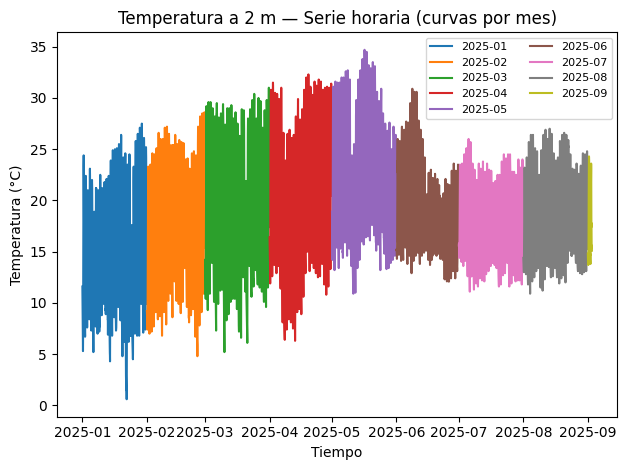

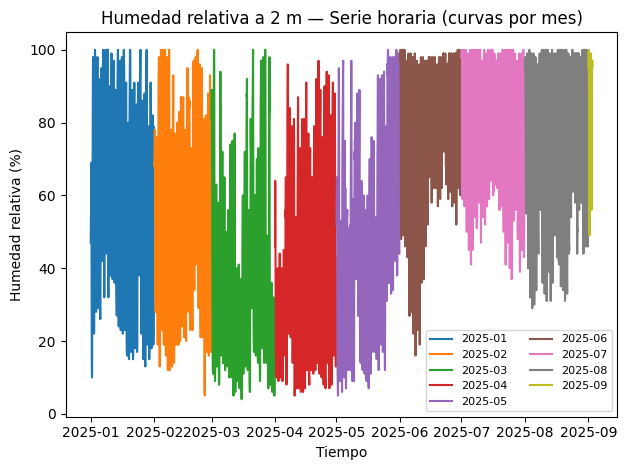

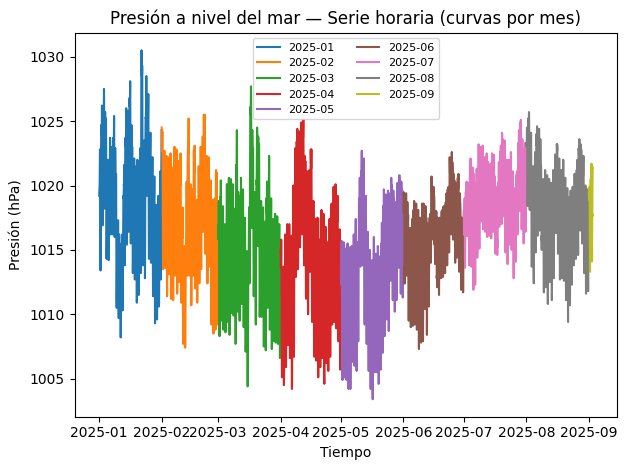

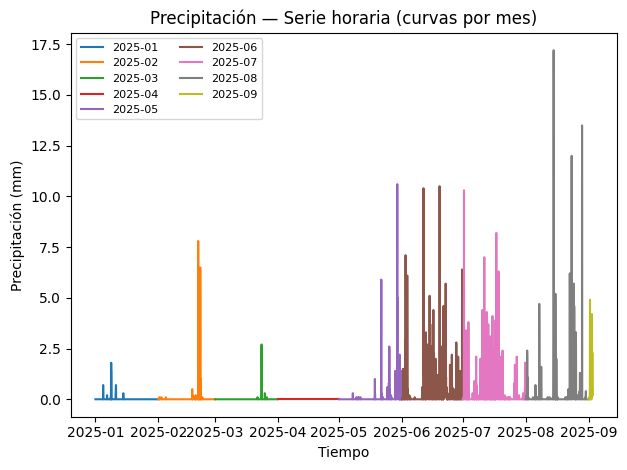

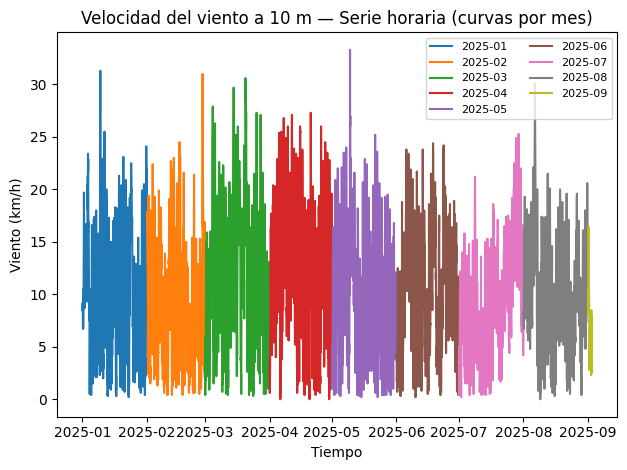

In [5]:
VARIABLES = [
    ("temperature_2m", "Temperatura (°C)", "Temperatura a 2 m"),
    ("relative_humidity_2m", "Humedad relativa (%)", "Humedad relativa a 2 m"),
    ("pressure_msl", "Presión (hPa)", "Presión a nivel del mar"),
    ("precipitation", "Precipitación (mm)", "Precipitación"),
    ("wind_speed_10m", "Viento (km/h)", "Velocidad del viento a 10 m"),
]

for col, ylabel, title in VARIABLES:
    PlotTimeSeriesOverlayByMonth(df, col, ylabel, title)


## 6) Por mes: curva típica por hora + evolución típica por día (con banda)

Meses disponibles: [Period('2025-01', 'M'), Period('2025-02', 'M'), Period('2025-03', 'M'), Period('2025-04', 'M'), Period('2025-05', 'M'), Period('2025-06', 'M'), Period('2025-07', 'M'), Period('2025-08', 'M'), Period('2025-09', 'M')]


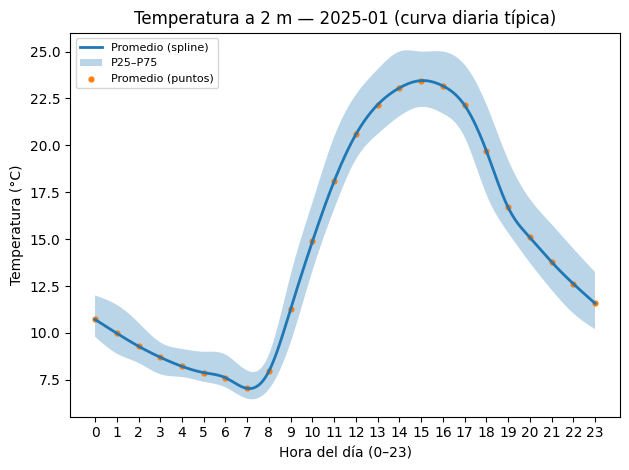

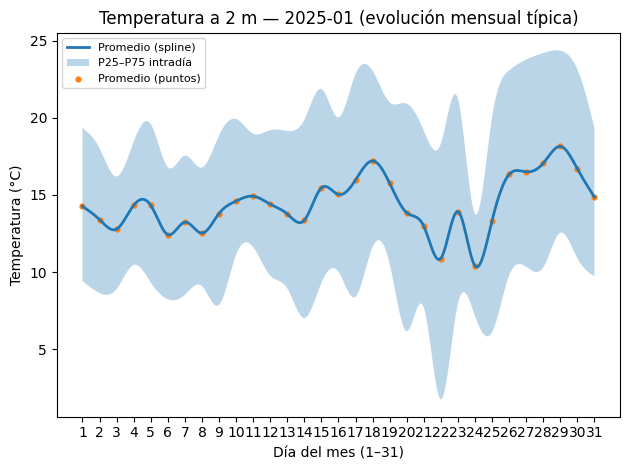

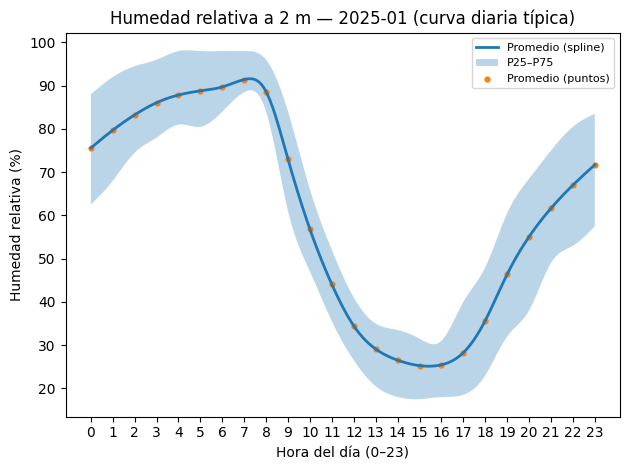

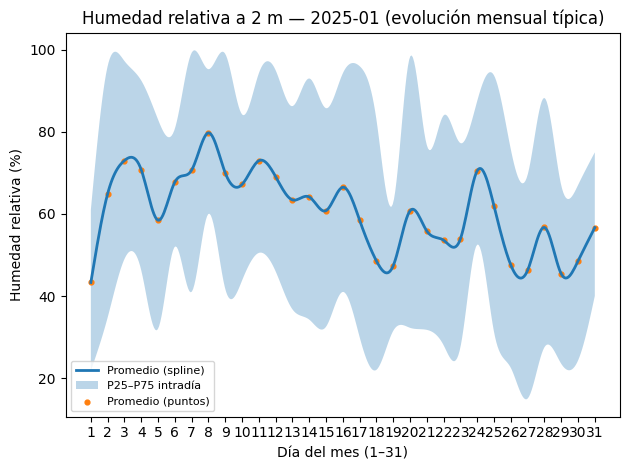

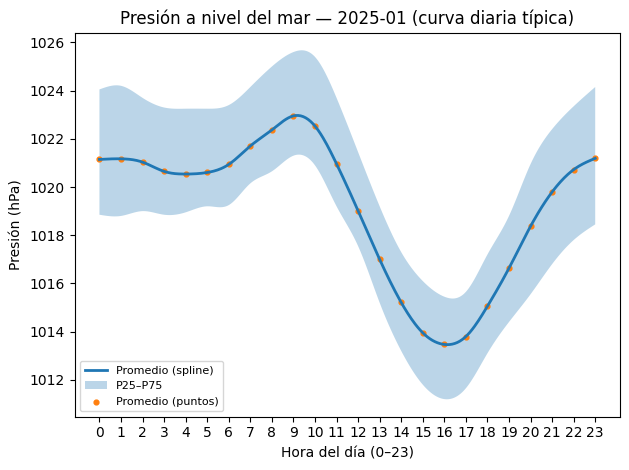

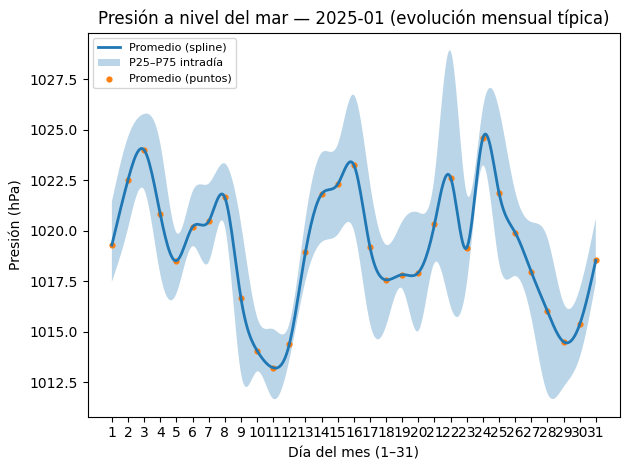

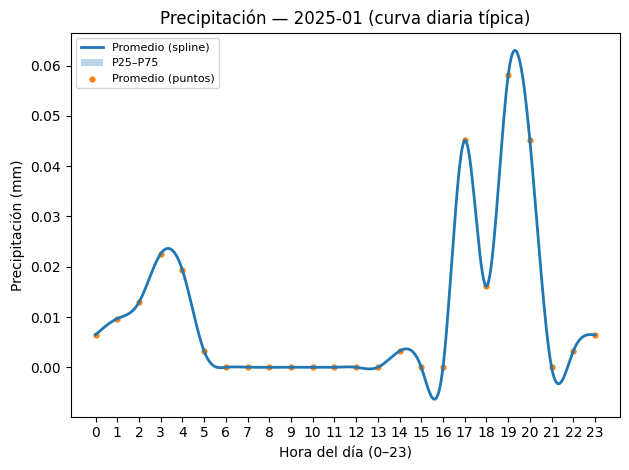

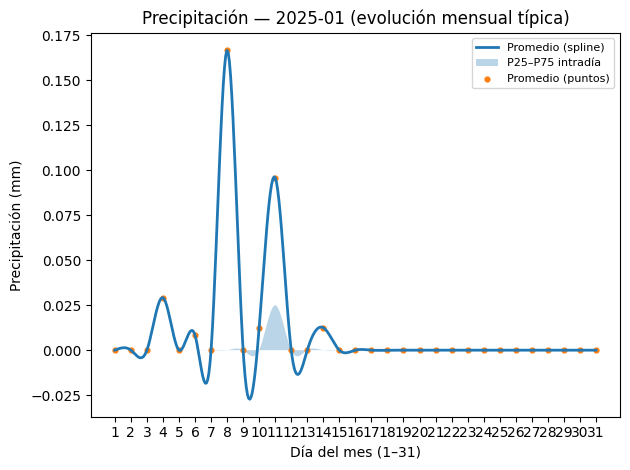

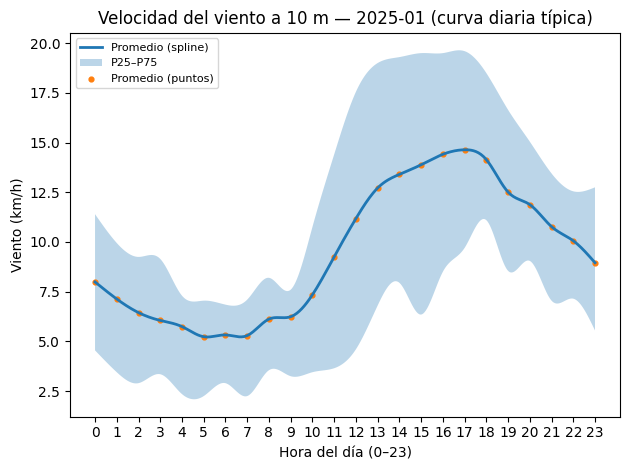

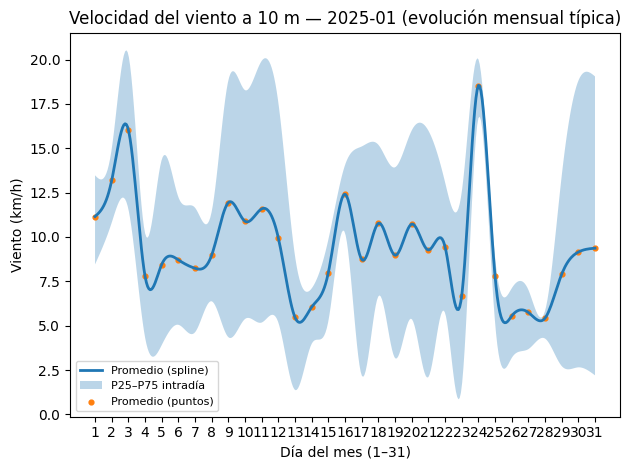

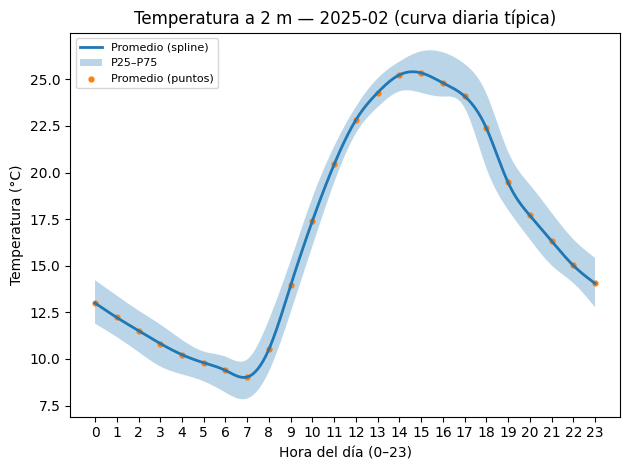

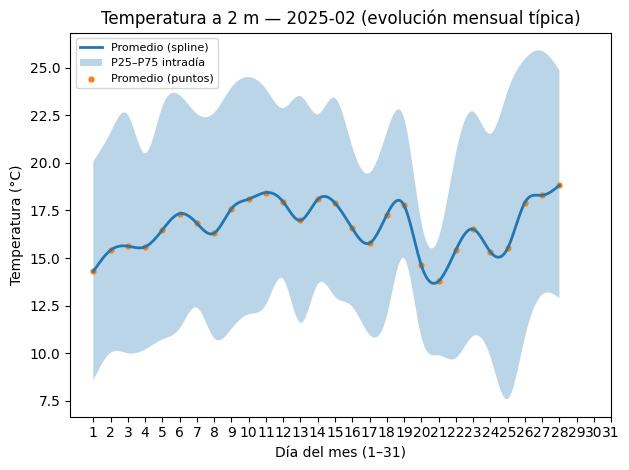

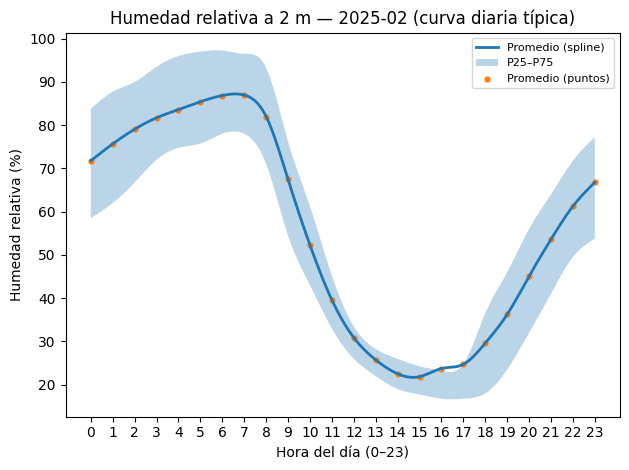

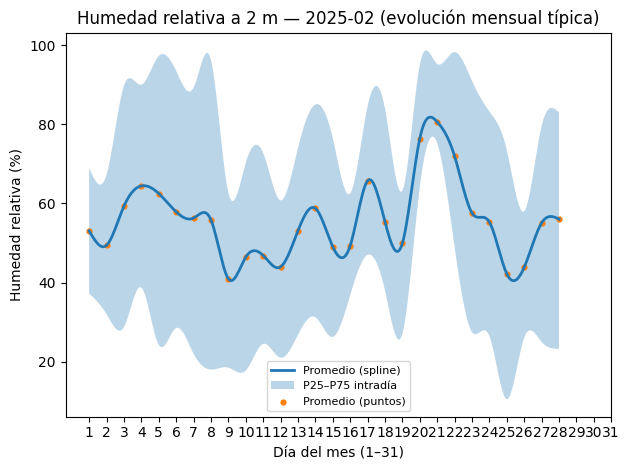

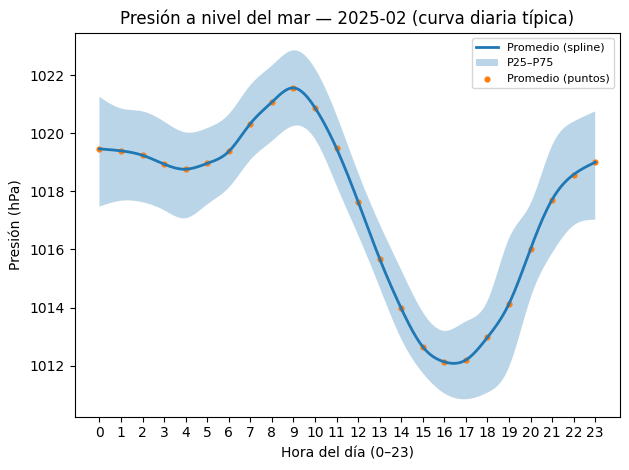

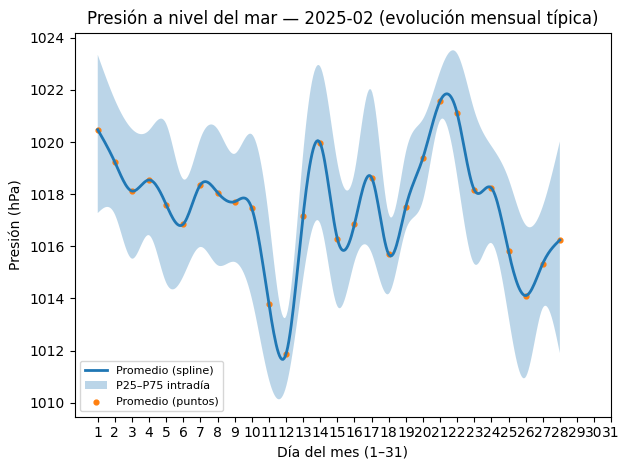

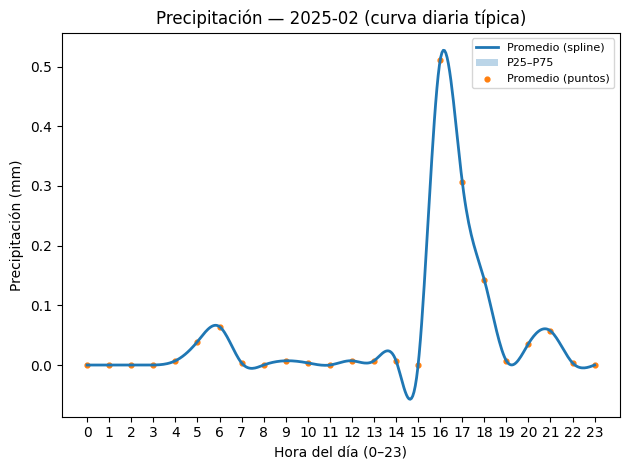

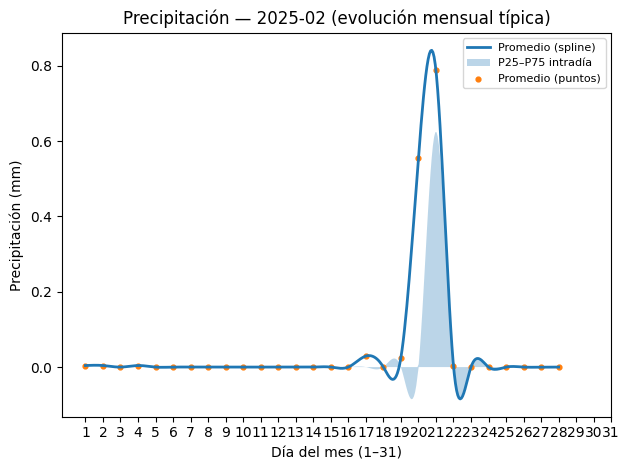

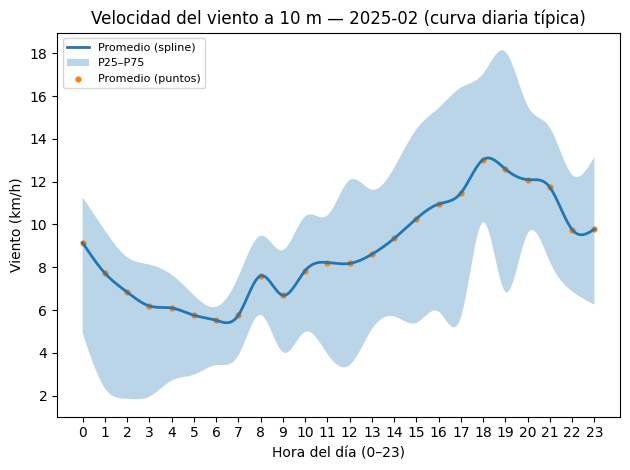

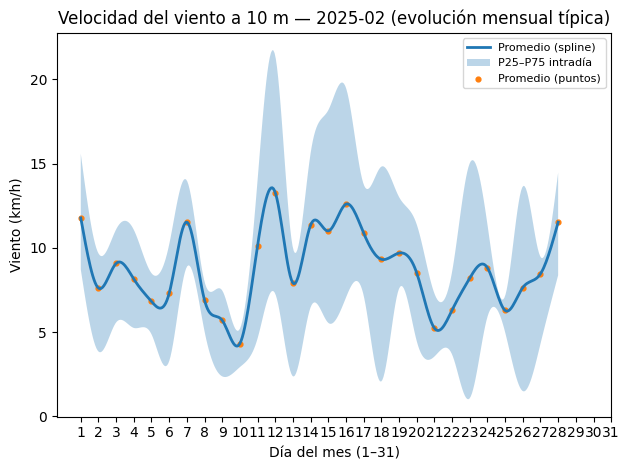

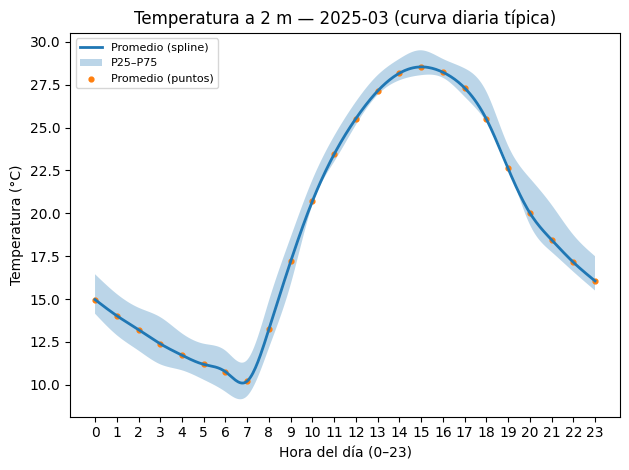

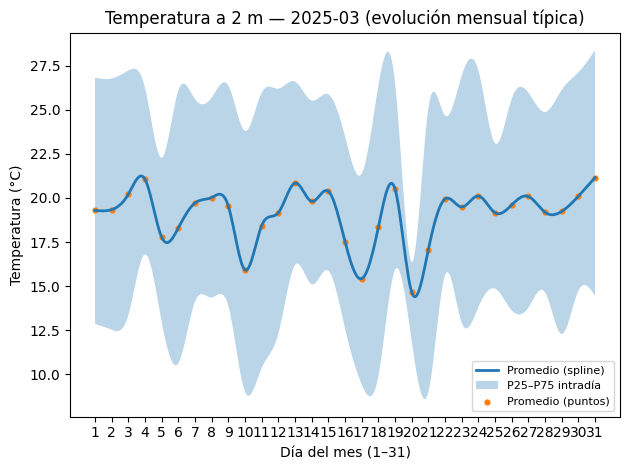

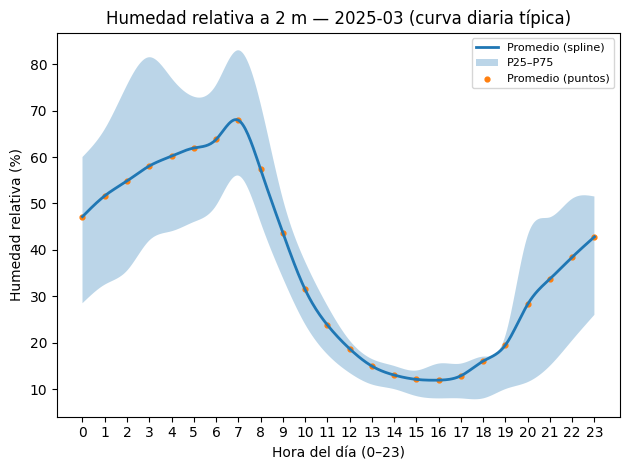

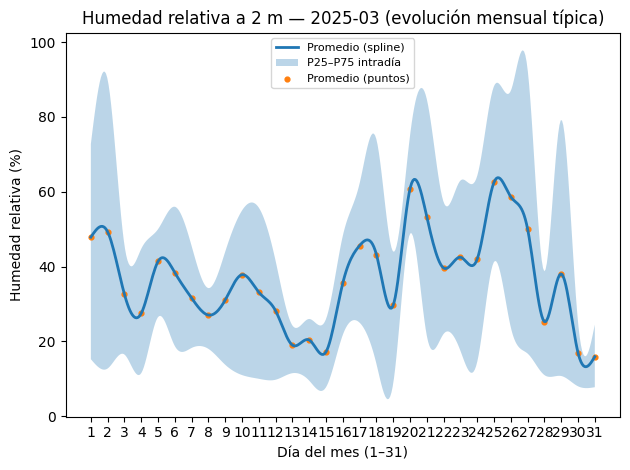

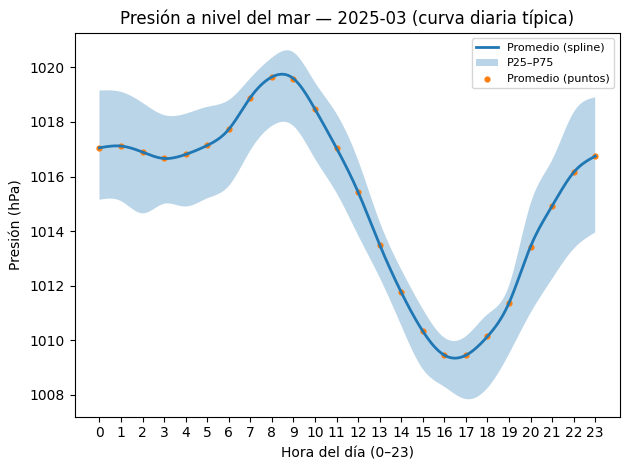

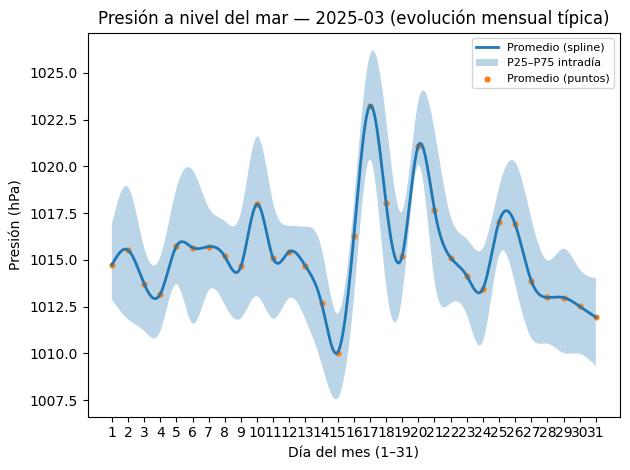

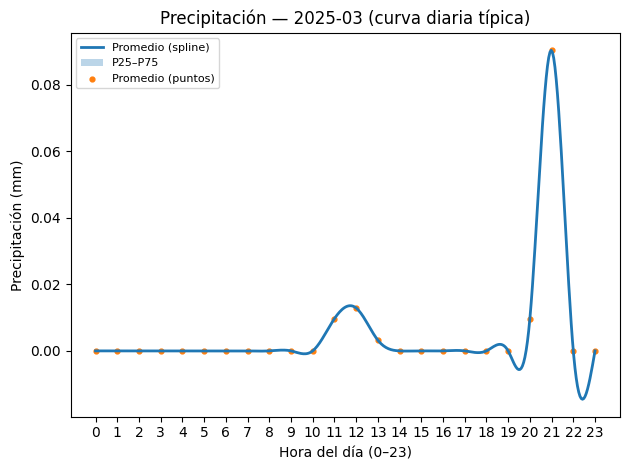

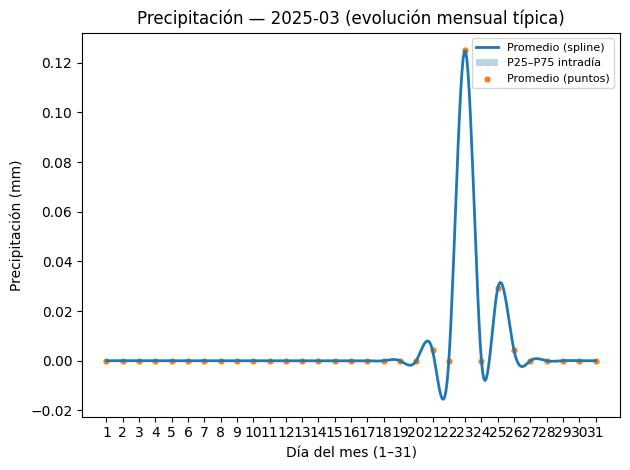

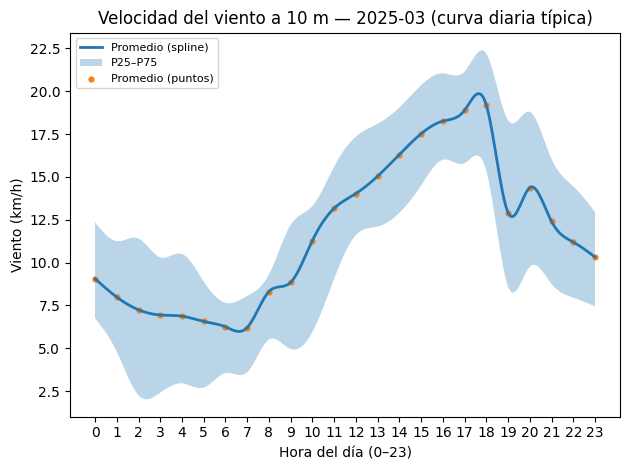

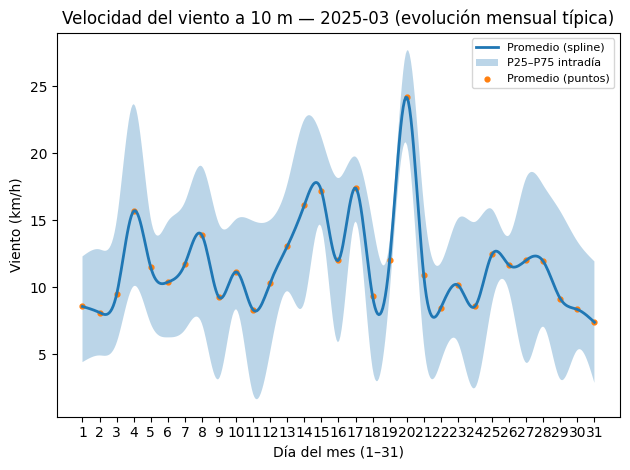

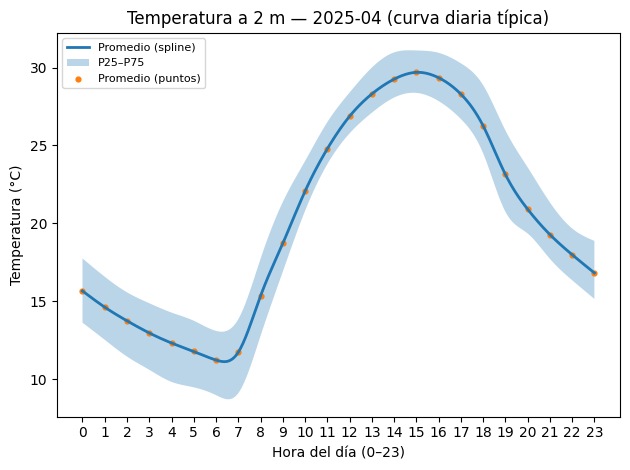

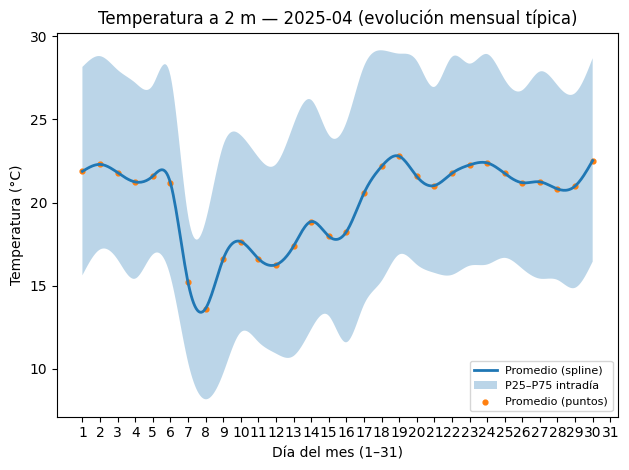

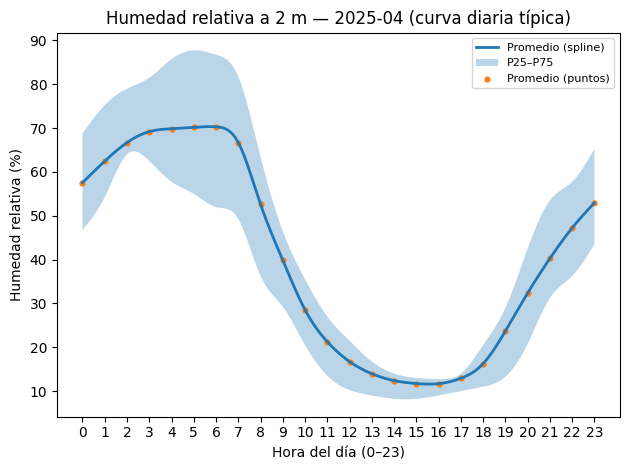

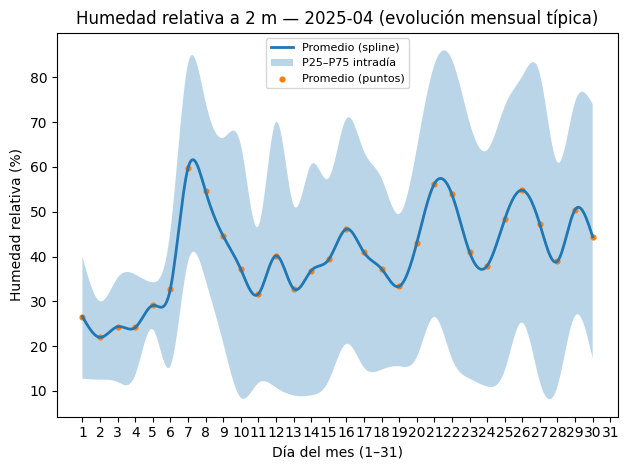

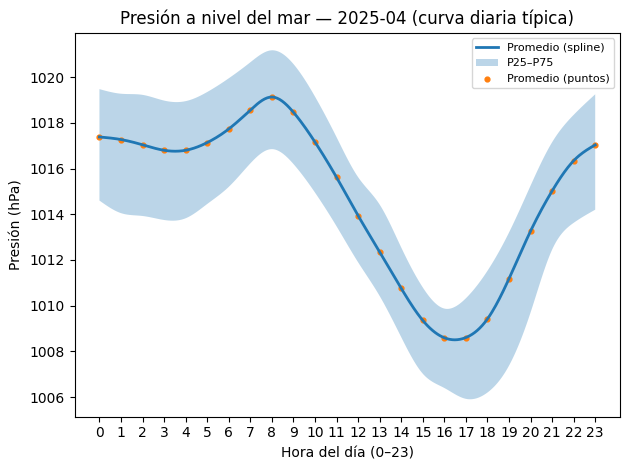

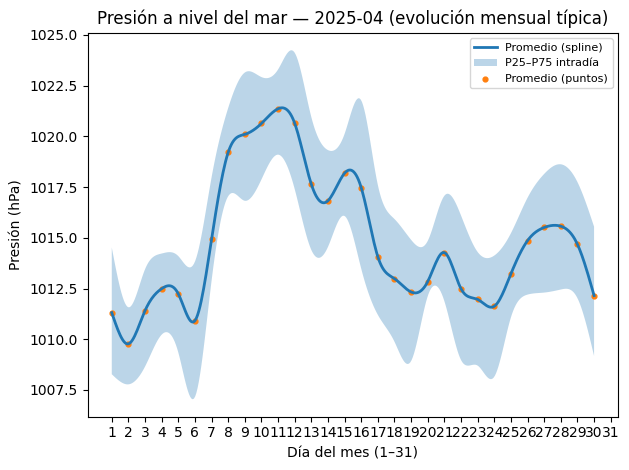

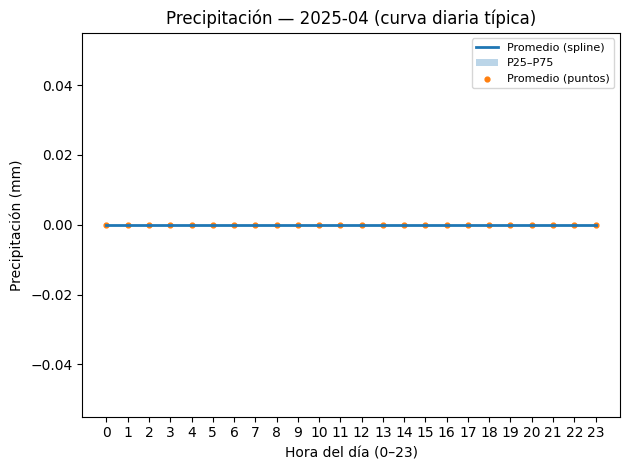

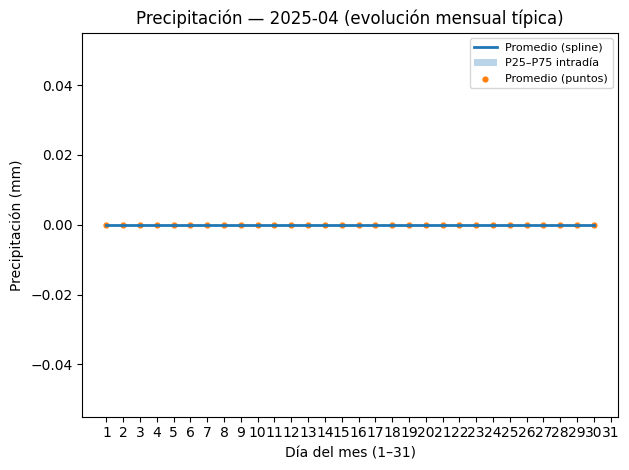

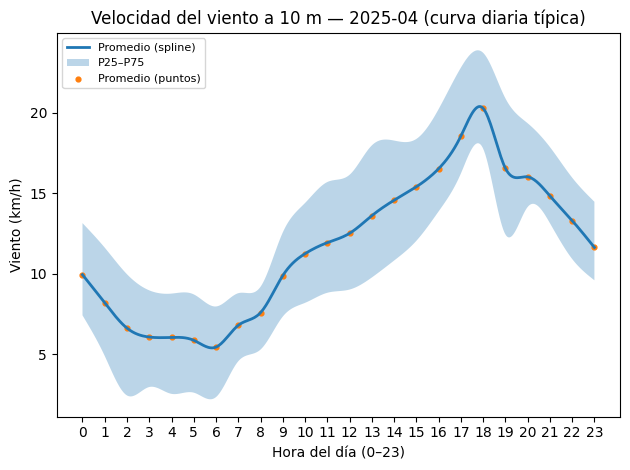

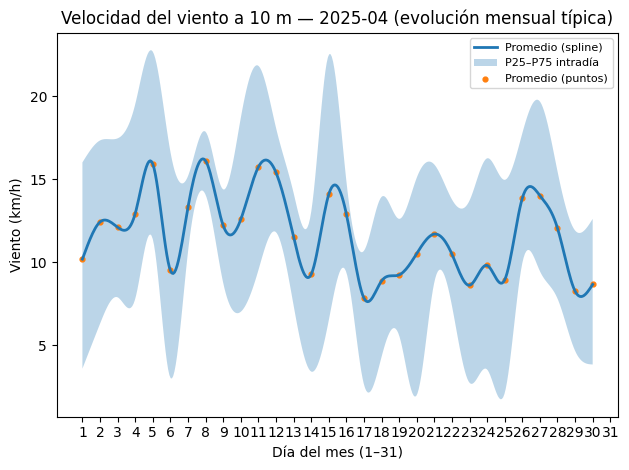

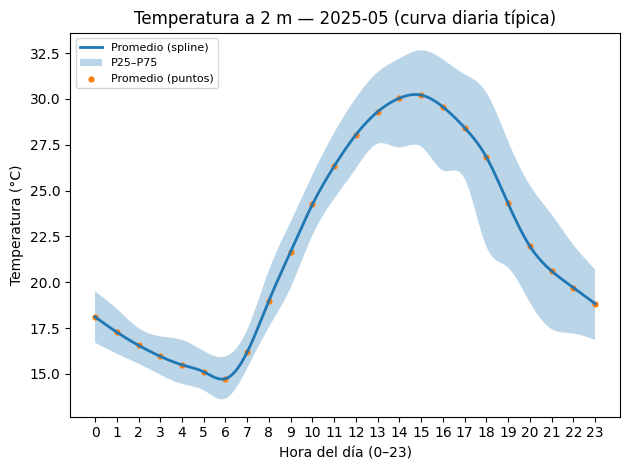

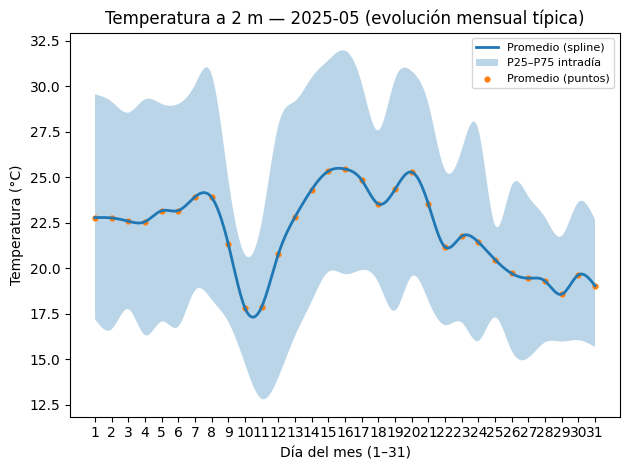

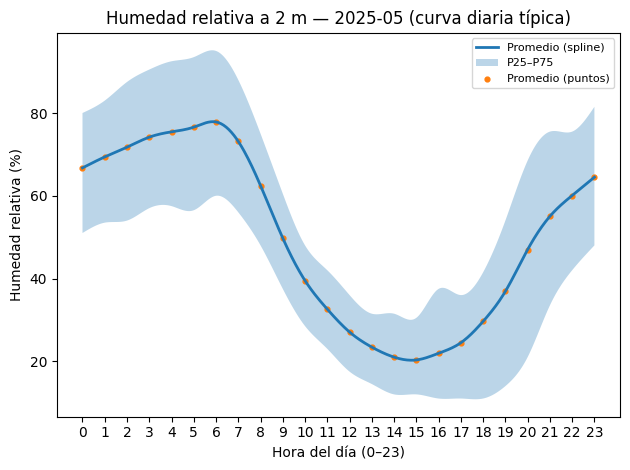

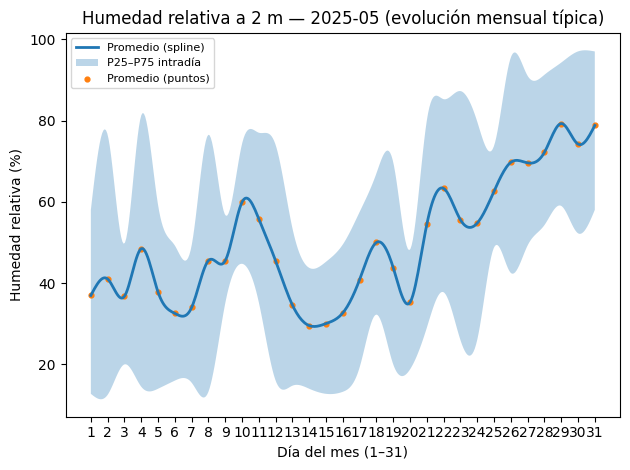

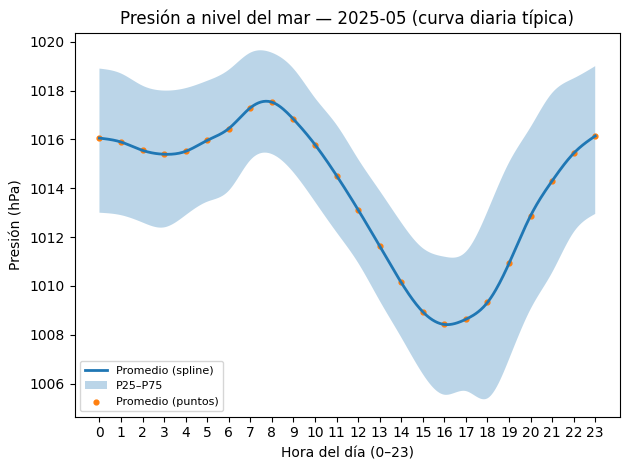

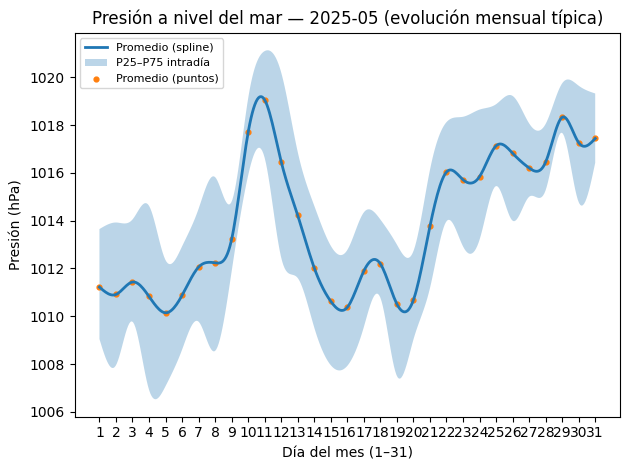

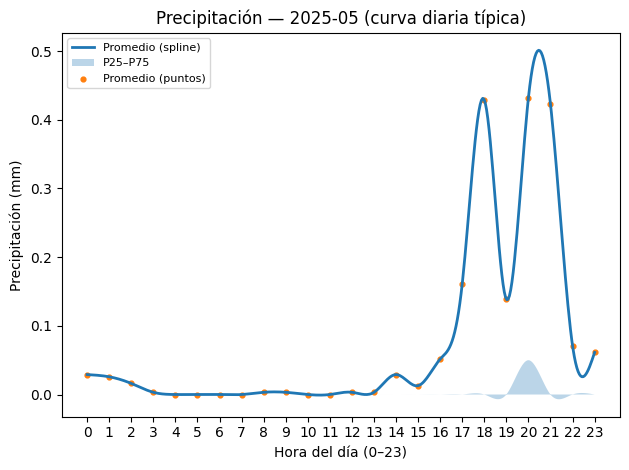

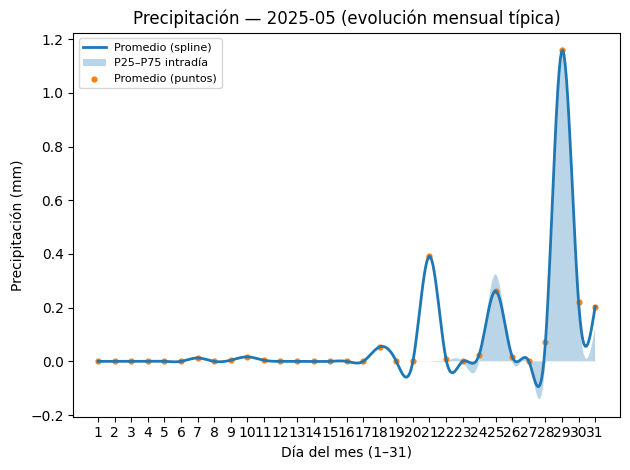

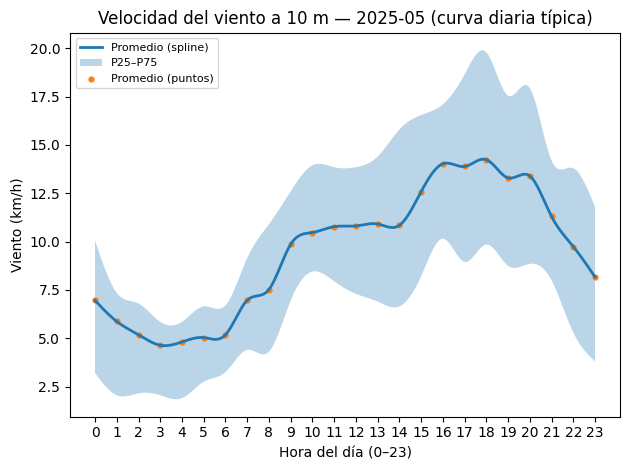

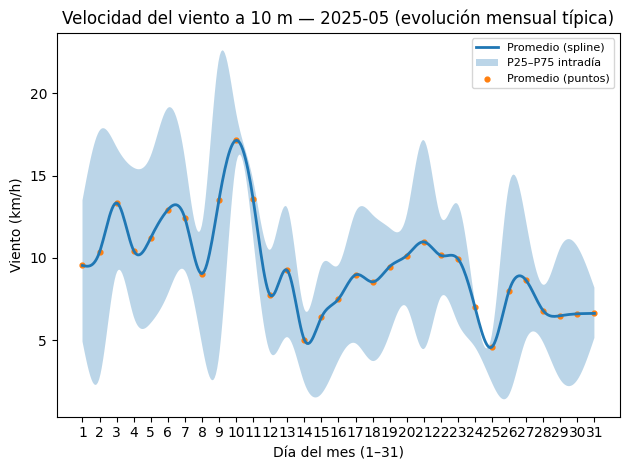

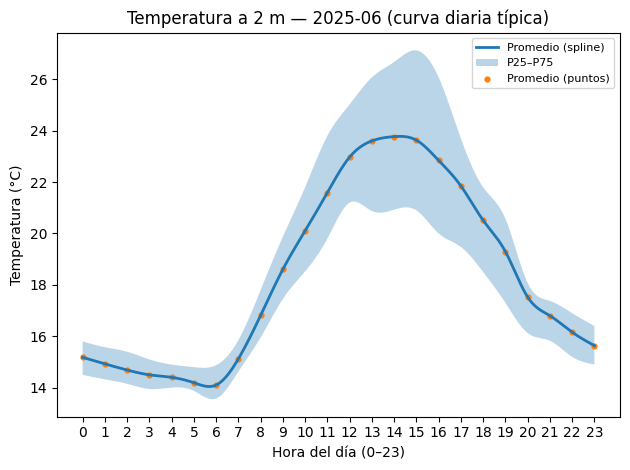

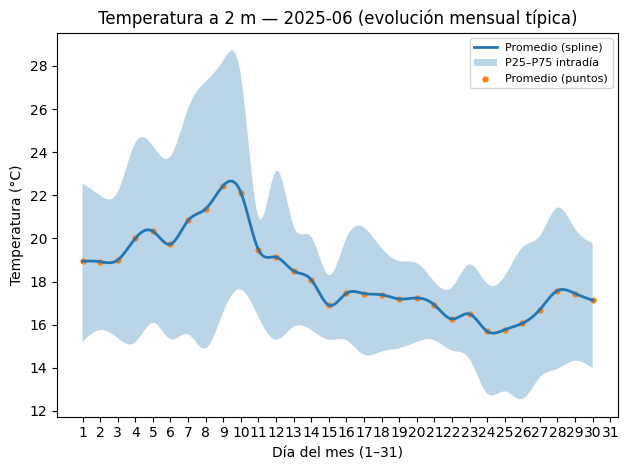

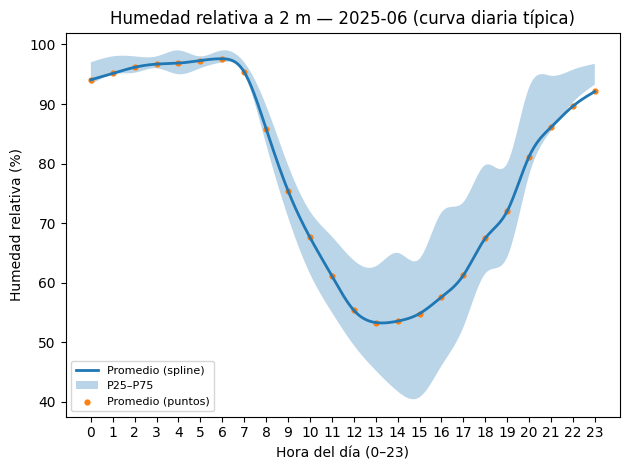

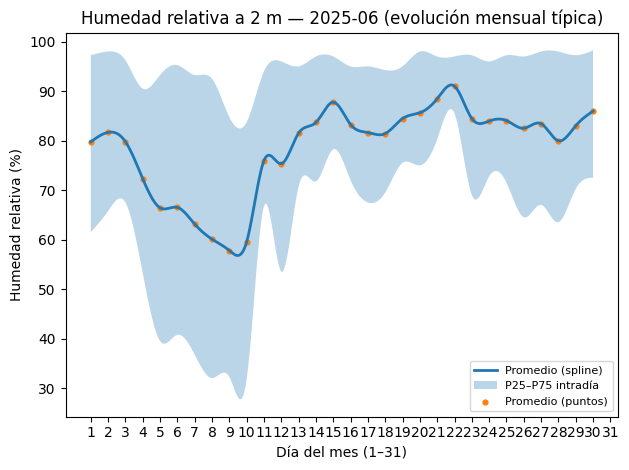

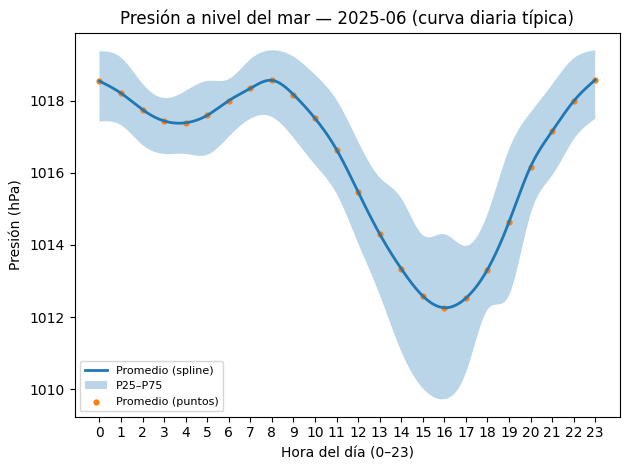

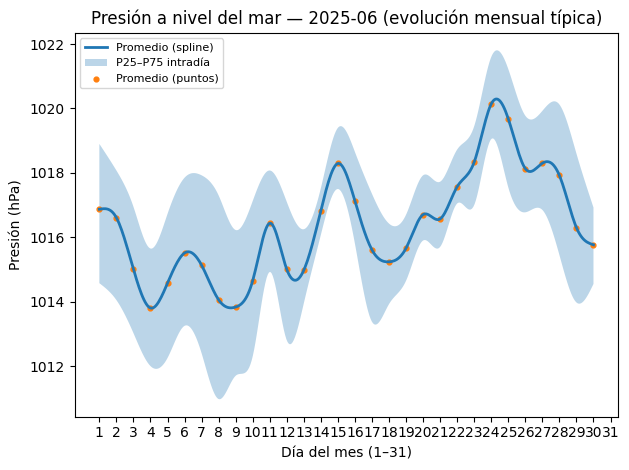

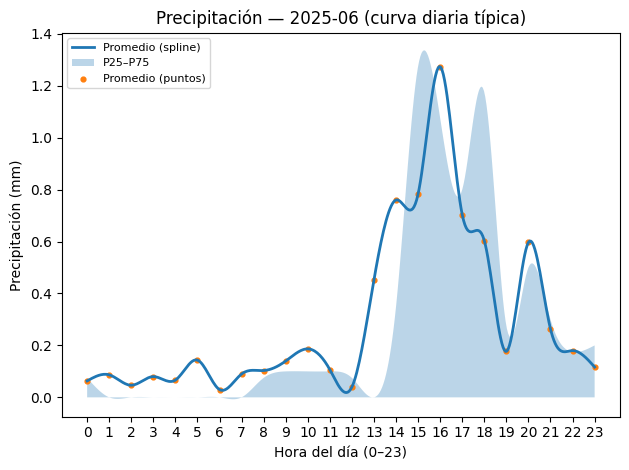

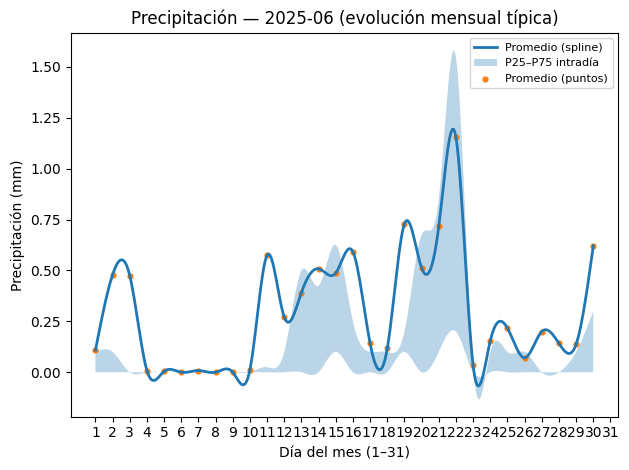

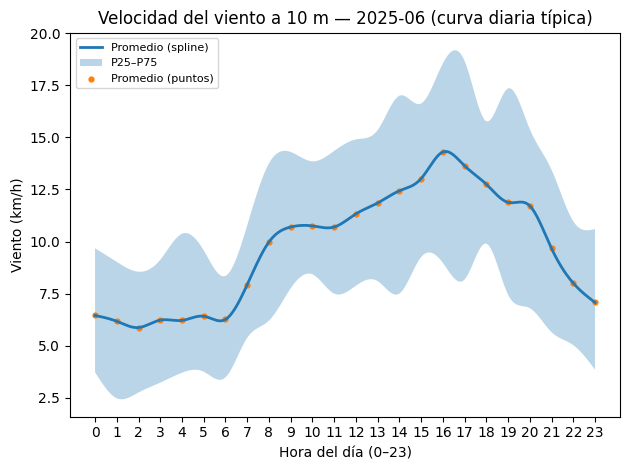

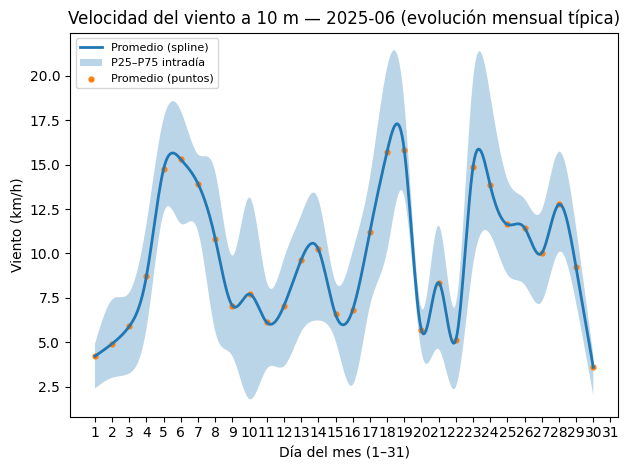

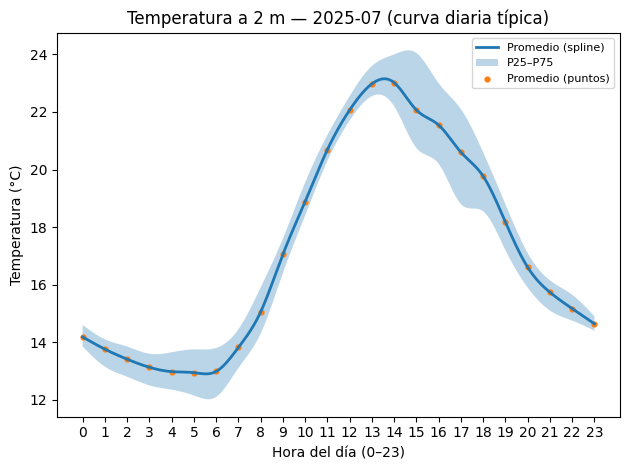

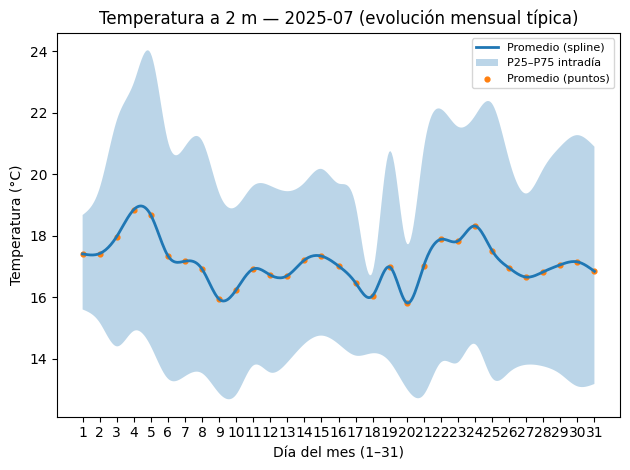

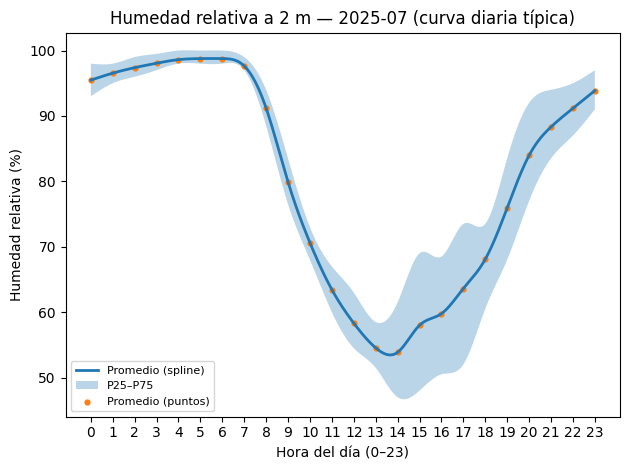

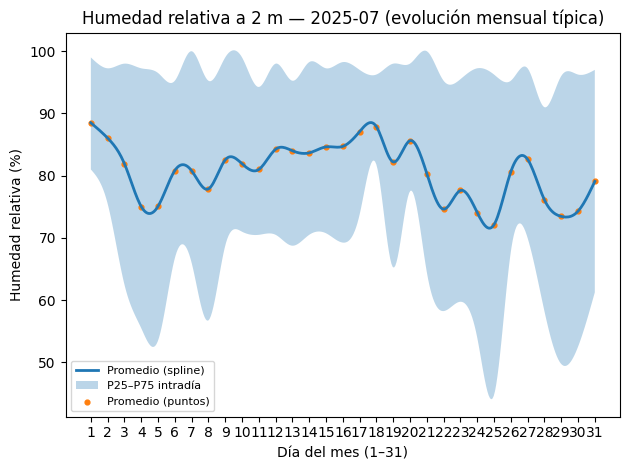

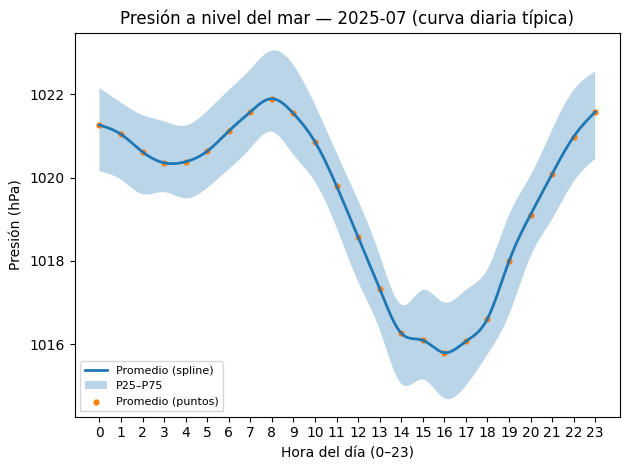

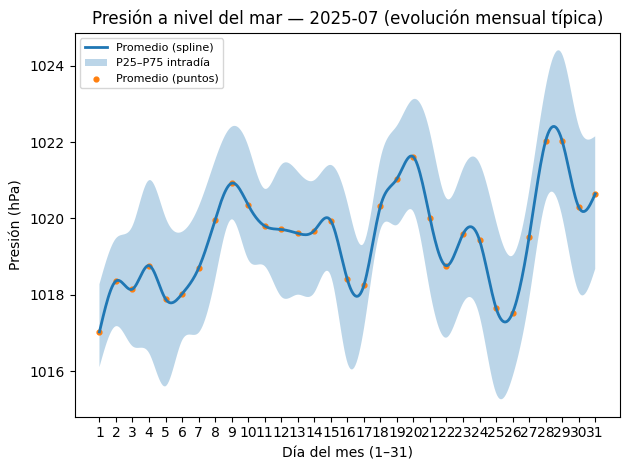

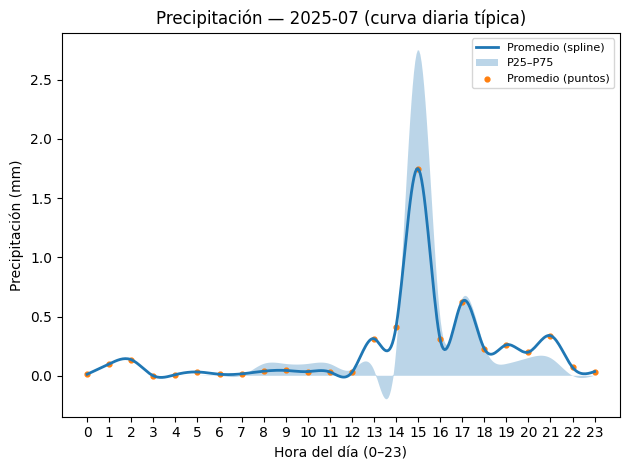

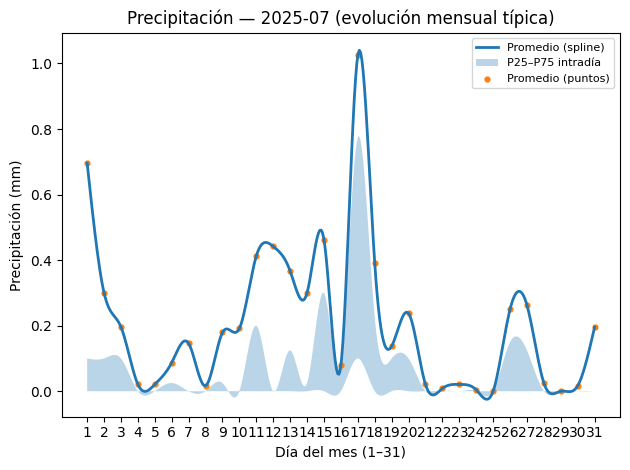

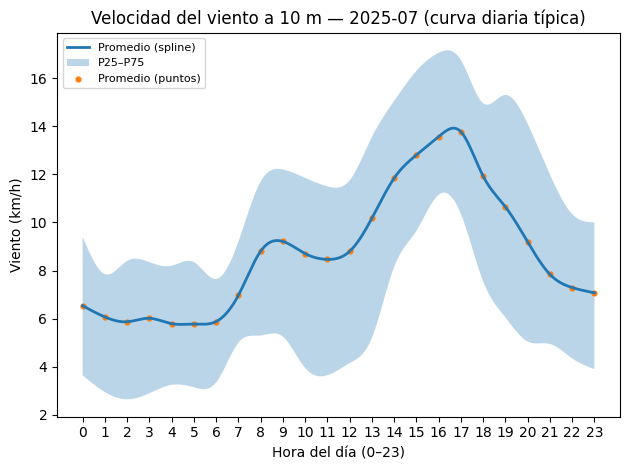

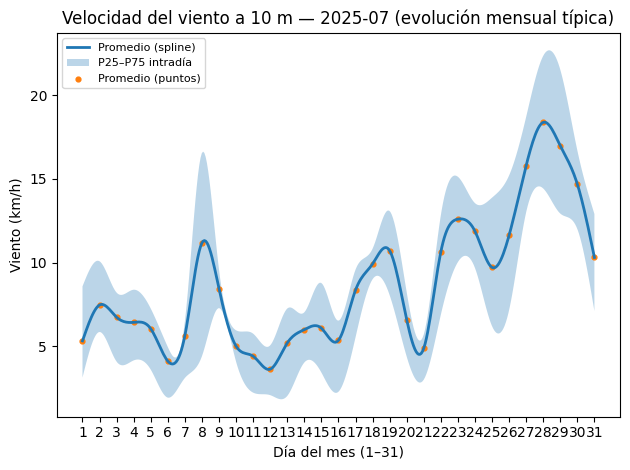

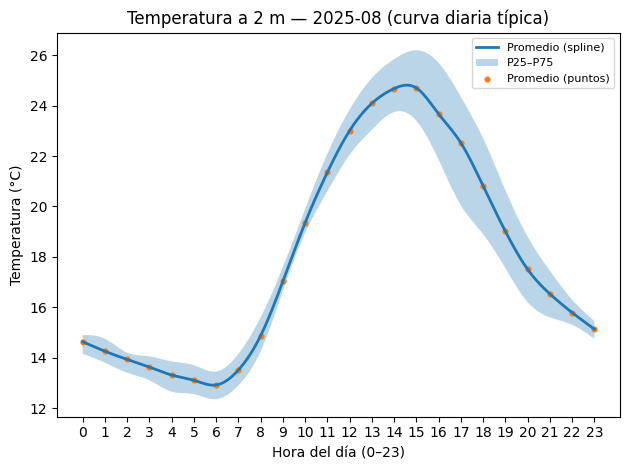

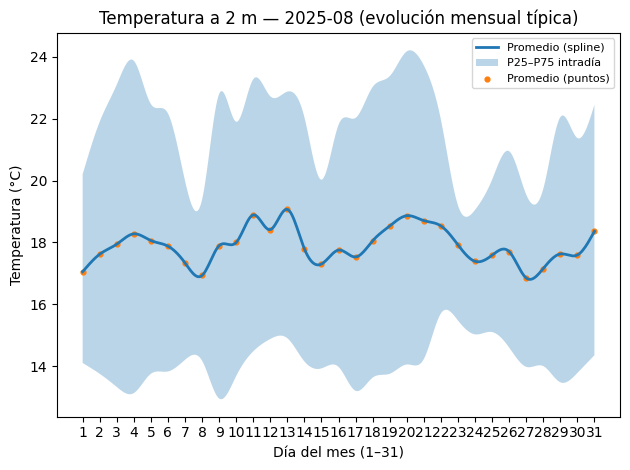

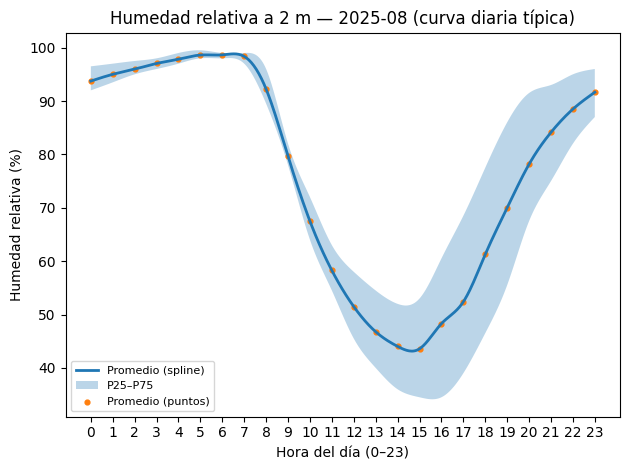

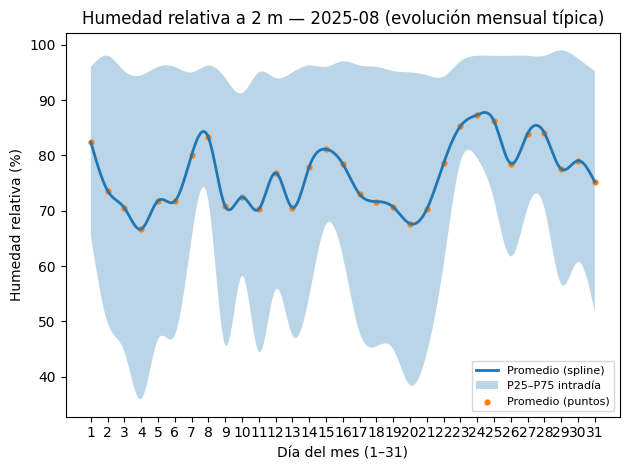

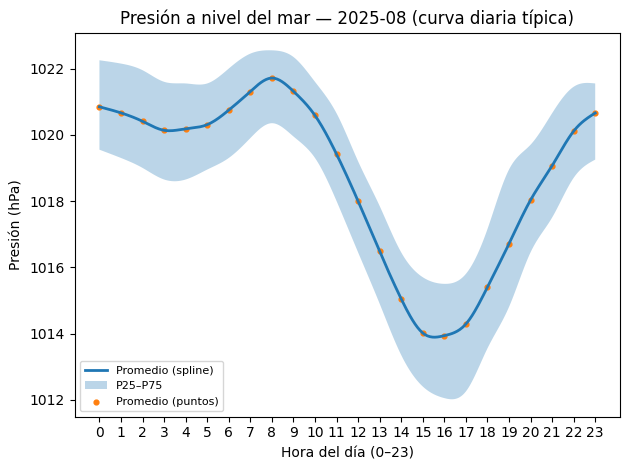

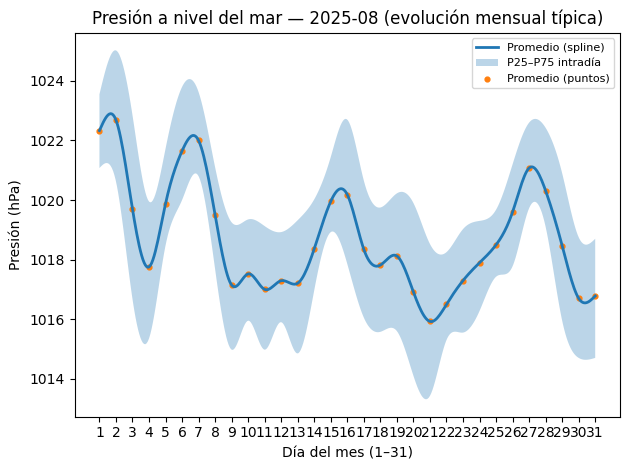

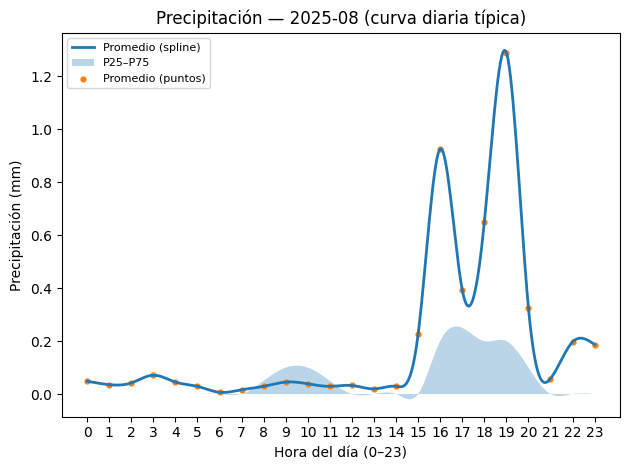

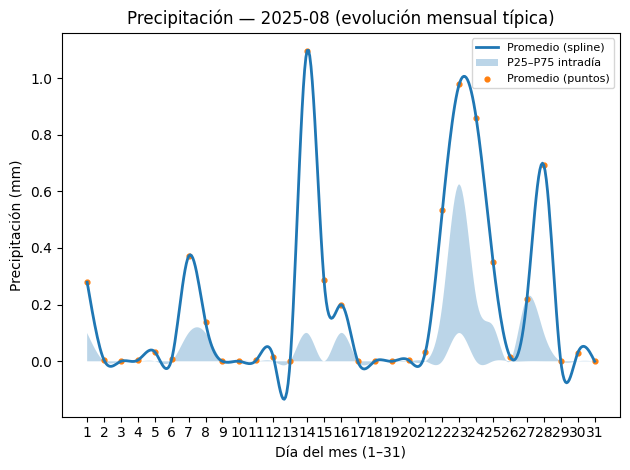

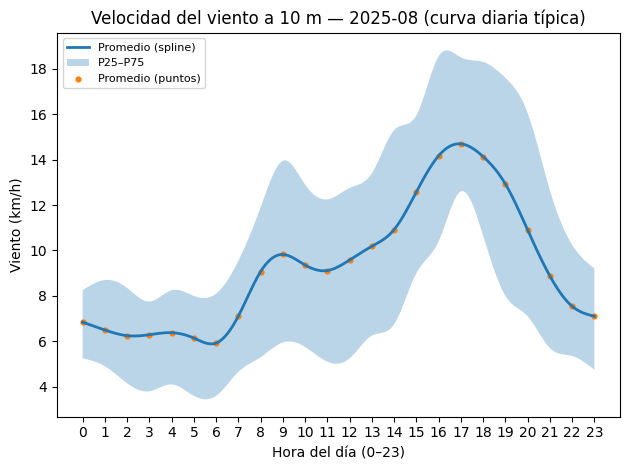

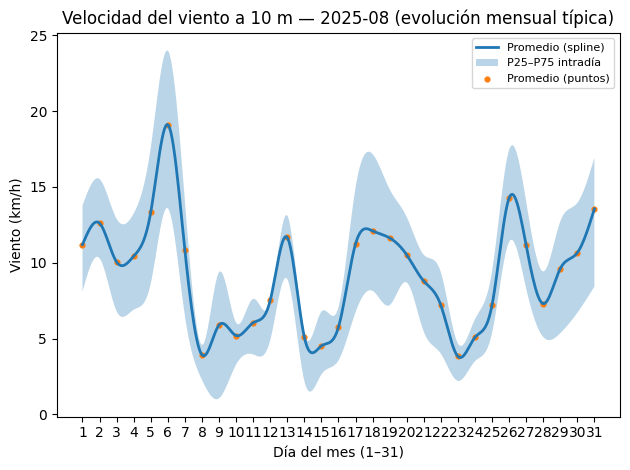

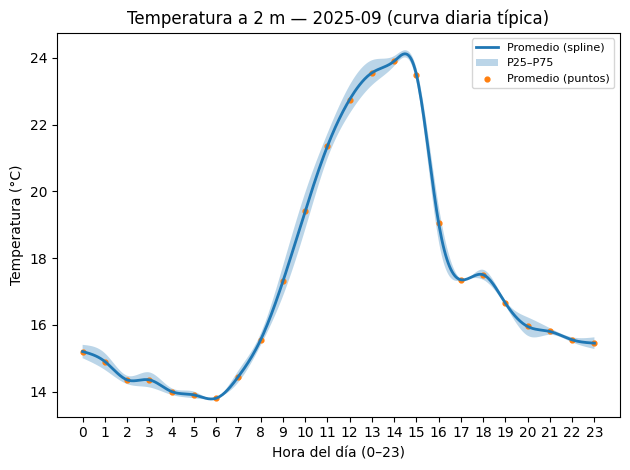

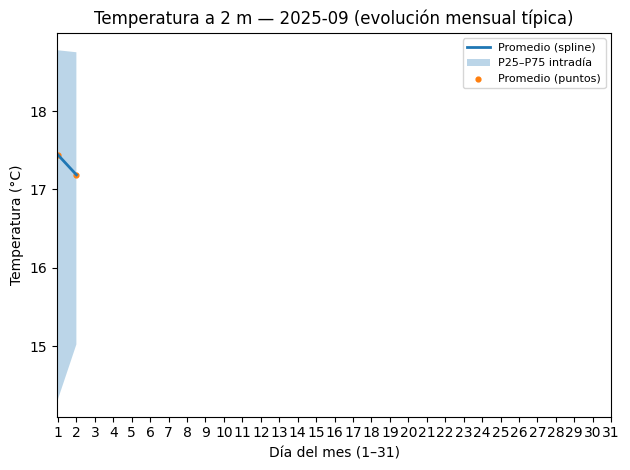

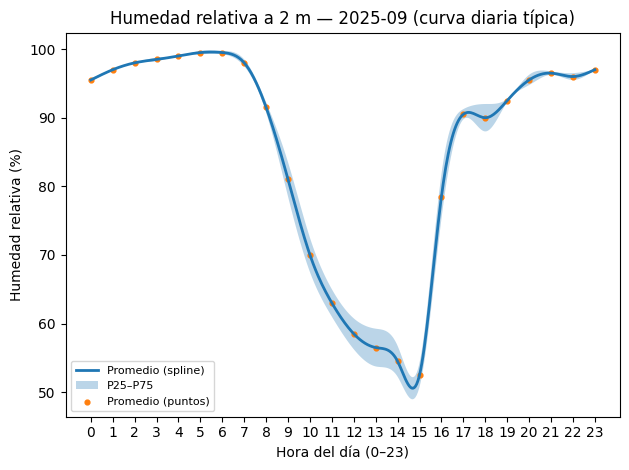

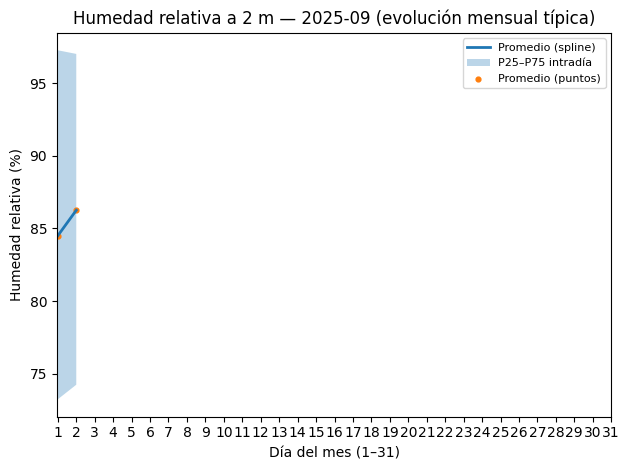

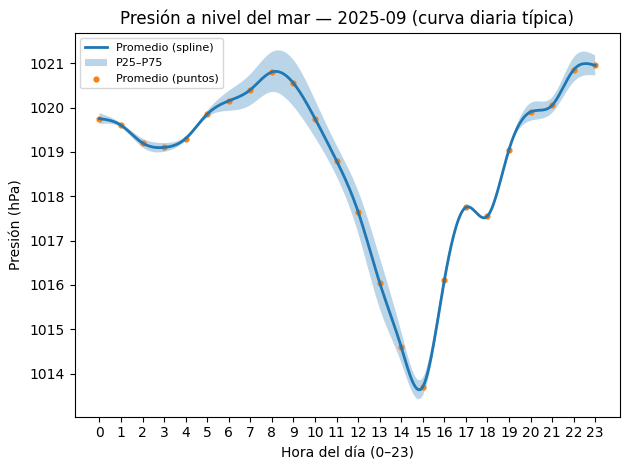

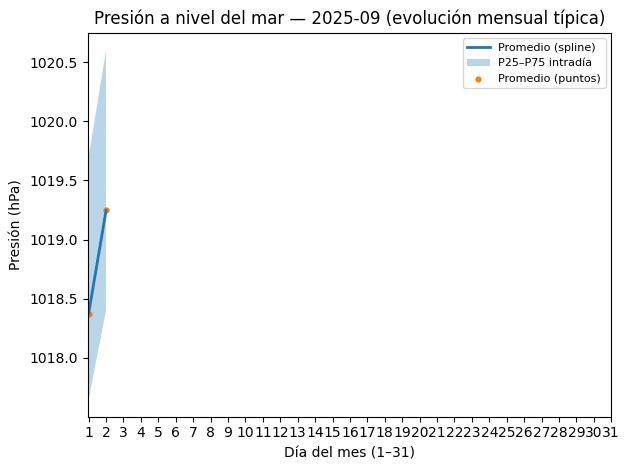

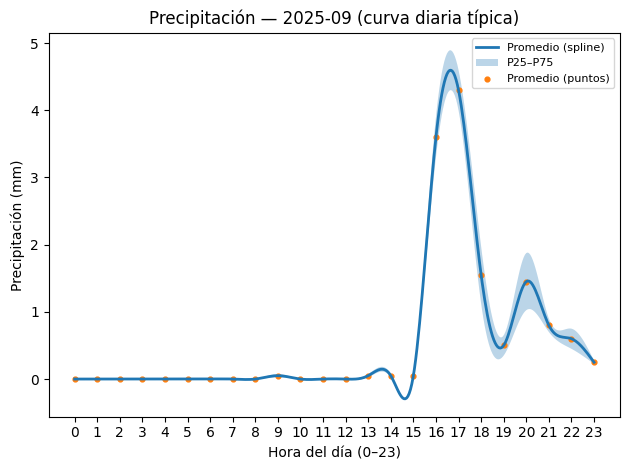

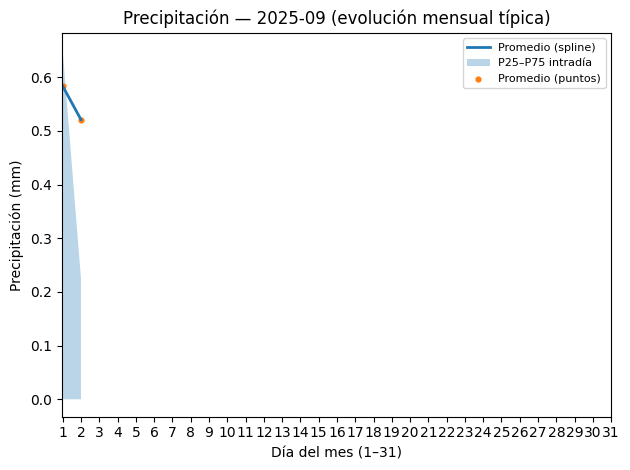

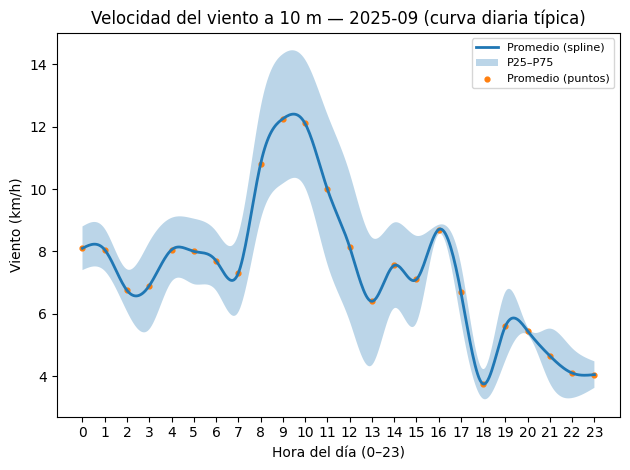

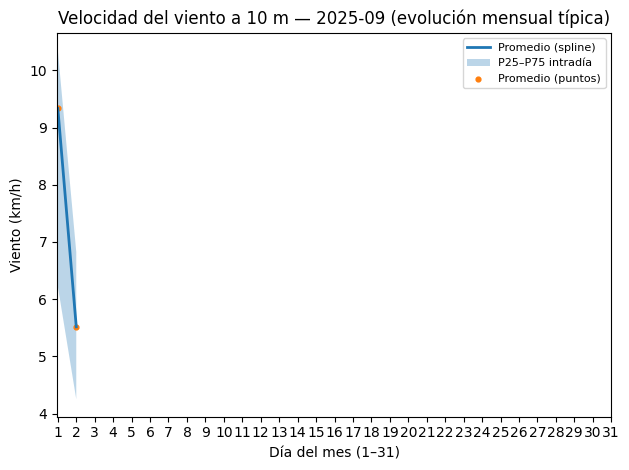

In [6]:
months = sorted(df["month"].unique())
print("Meses disponibles:", months)

for m in months:
    for col, ylabel, title in VARIABLES:
        # Curva típica diaria (0..23) con banda
        PlotHourlyClimatologyWithBand(df, m, col, ylabel, title, p_low=25, p_high=75, use_spline=True)

        # Evolución en el mes (1..31) con banda intradía
        PlotDayOfMonthIntradayBand(df, m, col, ylabel, title, p_low=25, p_high=75, use_spline=True)


## 7) Dashboard 4×3 (12 meses) — Promedio por día con banda
Este panel permite comparar rápidamente el **patrón mensual** en un solo vistazo.
Por defecto: `temperature_2m`. Puedes cambiar `DASH_COL`.

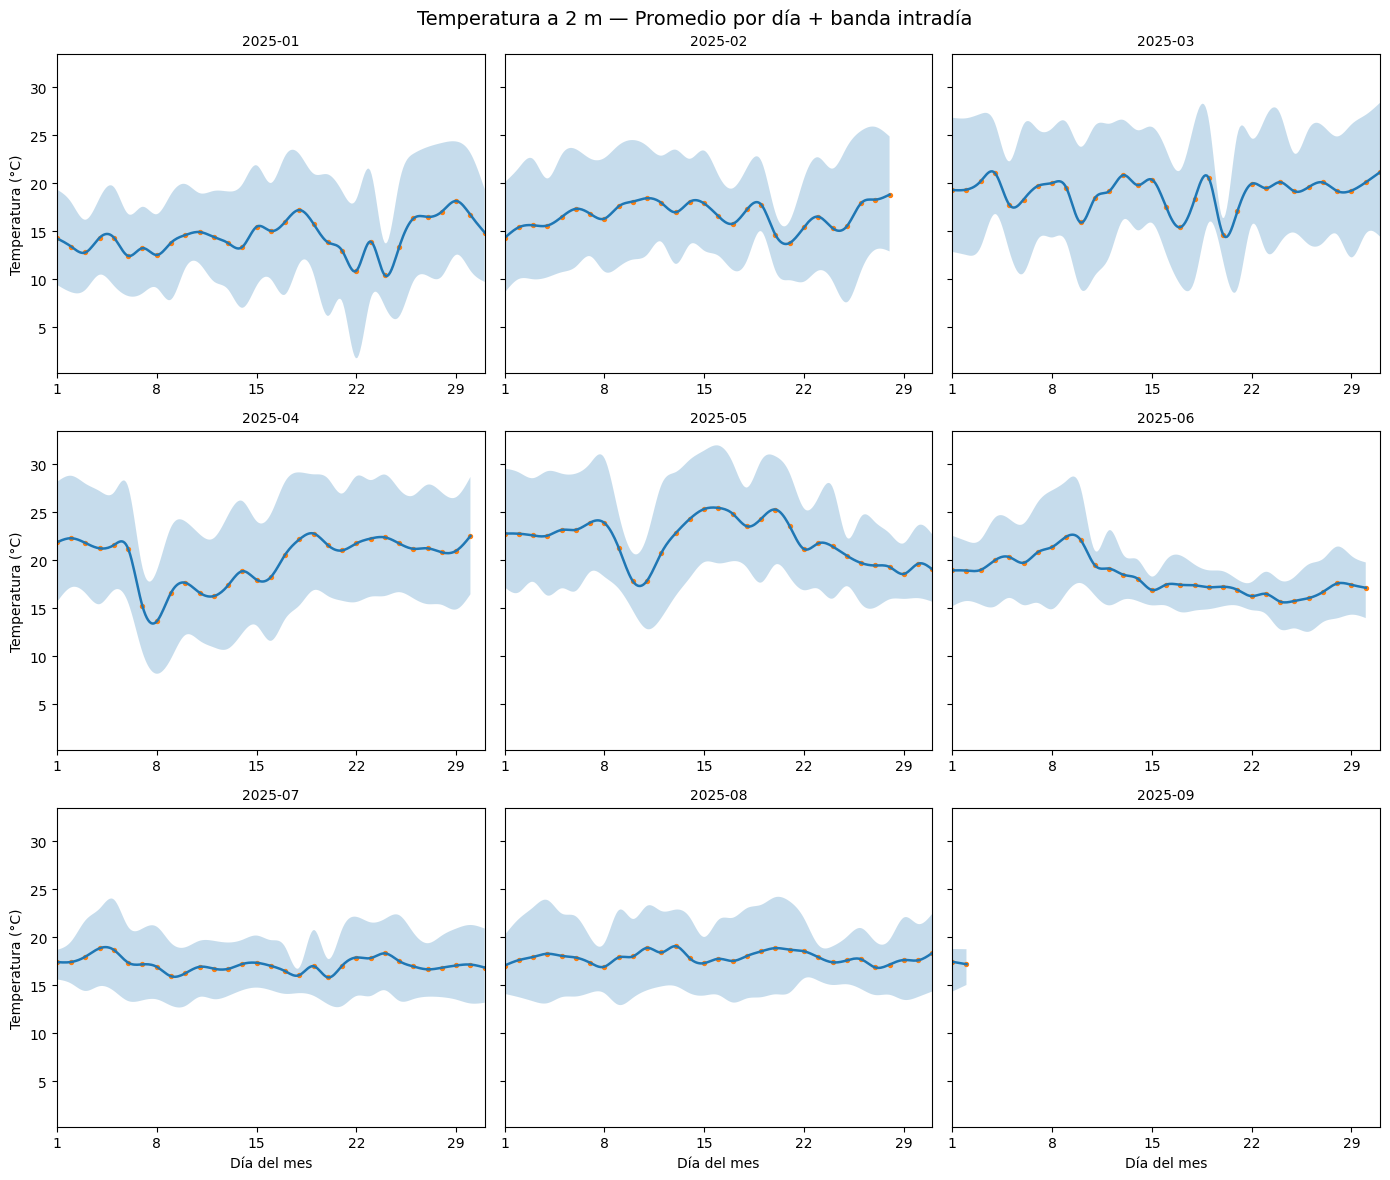

In [11]:
DASH_COL = "temperature_2m"
DASH_YLABEL = "Temperatura (°C)"
DASH_TITLE = "Temperatura a 2 m — Promedio por día + banda intradía"

# Si no hay 12 meses en el dataset, mostramos los disponibles
months = sorted(df["month"].unique())
n = len(months)

rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(14, 12), sharey=True)
axes = axes.ravel()

for i in range(rows*cols):
    ax = axes[i]
    if i >= n:
        ax.axis("off")
        continue

    m = months[i]
    dm = df[df["month"] == m].copy()

    per_date = (
        dm.groupby(["day","date"])[DASH_COL]
          .agg(
              mean="mean",
              plo=lambda s: s.quantile(0.25),
              phi=lambda s: s.quantile(0.75),
          )
          .reset_index()
          .dropna()
    )

    g = per_date.groupby("day").agg(
        mean=("mean","mean"),
        plo=("plo","mean"),
        phi=("phi","mean"),
    ).reset_index().sort_values("day")

    x = g["day"].to_numpy()
    y_mean = g["mean"].to_numpy()
    y_lo = g["plo"].to_numpy()
    y_hi = g["phi"].to_numpy()

    if len(x) >= 4:
        xs = np.linspace(x.min(), x.max(), 300)
        s_mean = CubicSpline(x, y_mean, bc_type="natural")
        s_lo   = CubicSpline(x, y_lo,   bc_type="natural")
        s_hi   = CubicSpline(x, y_hi,   bc_type="natural")

        yms = s_mean(xs)
        yls = s_lo(xs)
        yhs = s_hi(xs)

        yls2 = np.minimum(yls, yhs)
        yhs2 = np.maximum(yls, yhs)

        # FIX: precipitación no puede ser negativa
        if DASH_COL == "precipitation":
            yms  = np.clip(yms,  0, None)
            yls2 = np.clip(yls2, 0, None)
            yhs2 = np.clip(yhs2, 0, None)

        ax.plot(xs, yms, linewidth=1.8)
        ax.fill_between(xs, yls2, yhs2, alpha=0.25)
        ax.scatter(x, y_mean, s=8)
    else:
        if DASH_COL == "precipitation":
            y_mean = np.clip(y_mean, 0, None)
            y_lo   = np.clip(y_lo,   0, None)
            y_hi   = np.clip(y_hi,   0, None)

        ax.plot(x, y_mean, linewidth=1.8)
        ax.fill_between(x, y_lo, y_hi, alpha=0.25)
        ax.scatter(x, y_mean, s=8)

    ax.set_title(str(m), fontsize=10)
    ax.set_xlim(1, 31)
    ax.set_xticks([1, 8, 15, 22, 29])

for r in range(rows):
    axes[r*cols].set_ylabel(DASH_YLABEL)

for c in range(cols):
    axes[(rows-1)*cols + c].set_xlabel("Día del mes")

fig.suptitle(DASH_TITLE, fontsize=14)
plt.tight_layout()
plt.show()


## 8) Tips de lectura
- Banda estrecha: días más estables.
- Banda ancha: variabilidad intradía (frentes, nubes, viento, etc.).
- Cambios de nivel entre meses: estacionalidad.
- Para precipitación: suele convenir sumar por día y comparar eventos (picos).

In [10]:
cols_export = [
    "time",
    "temperature_2m",
    "relative_humidity_2m",
    "pressure_msl",
    "precipitation",
    "wind_speed_10m",
]

df[cols_export].to_csv(
    "clima_horario_openmeteo_2025.csv",
    index=False
)
